In [1]:
import numpy as np
from scipy.optimize import minimize,fsolve,brentq
from scipy.interpolate import interp1d
from scipy.integrate import simps
import matplotlib.pyplot as plt
import StreamModel as sm
import emcee
import corner

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def logGaussian(data,model,std):
    loggauss =  -(data-model)**2*0.5/std**2
    return loggauss

In [3]:
def calc_dpsi(stream,psi0):

    gam = stream.calc_gamma()
    gT = stream.gT()
        
    t = stream.t
    r0 = stream.r0
    vy = stream.vy
    wperp  = stream.wperp
    wpar = stream.wpar
    wvec = stream.wvec
    w = stream.w
    b = stream.b
    rs = stream.rs
    
    tau = w*r0**2/2./stream.G/stream.m
        
    f = (4.-gam**2)/gam**2*t/tau - 4.*np.sin(gT)/gam**3*r0/vy/tau+2.*(1.-np.cos(gT))/gam**2*wpar*wvec[0]/wperp**2*r0/vy/tau
    g = 2.*(1-np.cos(gT))*b*w**2*wvec[2]*r0/(gam**2*r0*wperp**3*vy*tau)
    B2 = (b**2+rs**2)*w**2/(r0**2*wperp**2)
    
    dpsi = 1.+(f*B2-f*psi0**2+2.*g*psi0)/(psi0**2+B2)**2

    return dpsi

In [4]:
def logLikelihood(guess,data,std):
    
    mass = np.exp(guess[0])*1.e8
    rs = guess[1]*625.
    b = guess[2]
    wx = guess[3]
    wy = guess[4]
    wz = guess[5]
    time = guess[6]
    
    if (np.sqrt((wx**2+wz**2))<np.abs(wy)):
        return -np.inf
    
    psidata = data[0]
    dxdata = data[1]
    dxdotdata = data[2]
    
    ns = len(psidata)
    nsSTD = round(ns*0.05)
    
    if (nsSTD < 2):
        print('The number of points to calculate the std of the data was',nsSTD,'that\'s too small.')
        return 
        
    dxstd = [np.std(dxdata[0][:(nsSTD)]),np.std(dxdata[1][:(nsSTD)]),\
             np.std(dxdata[2][:(nsSTD)])]
    dxdotstd = [np.std(dxdotdata[0][:(nsSTD)]),np.std(dxdotdata[1][:(nsSTD)]),\
                np.std(dxdotdata[2][:(nsSTD)])]

    sigma = 150.
    
    Mstream = sm.Stream(mass,9800.,rs,b,[wx,wy,wz],time,psi0=[np.min(psidata),np.max(psidata)])
    mpsi0 = Mstream.psi0
    mpsi = Mstream.psi
    
    dpsi = np.array([(mpsi[i+1]-mpsi[i]) for i in range(len(mpsi)-1)])
    
    if (len(dpsi[dpsi<0])>0):
        
        halfL = int(len(mpsi)/2)

        # Find the roots of the dpsi function (outer two)
        root1 = fsolve(lambda x:calc_dpsi(Mstream,x),-1.)
        root4 = fsolve(lambda x:calc_dpsi(Mstream,x),1.)
        
        if root1>0 and root4<0:
            root = root1
            root1=root4
            root4=root
        
        while True:
            try:
                root1 = brentq(lambda x:calc_dpsi(sMstream,x),-10.,mpsi0[max1-1])
                root4 = fsolve(lambda x:calc_dpsi(Mstream,x),-root1)          
            except:
                break
            
        #Find the location of the nearest point in the model to the First and last maximum and minimum
        max1 = np.argmin(np.abs(mpsi0[:halfL]-root1))
        min1 = np.argmin(np.abs(mpsi0[halfL:]-root4))+halfL
        
        psimax1 = mpsi[max1]
        psimin1 = mpsi[min1]
        
        if (psimax1<np.min(psidata) and psimin1>np.max(psidata)):
            psi0func = interp1d(mpsi,mpsi0)
            psi0data = psi0func(psidata)

        else:
    
            #Recalculate the model between the two roots
            sMstream = sm.Stream(mass,9800.,rs,b,[wx,wy,wz],time,psi0=[mpsi0[max1+1],mpsi0[min1-1]])
        
            smpsi = sMstream.psi
            smpsi0 = sMstream.psi0
        
            #Recalculate on the new, smaller range to find the last two roots
            try:  
                root2 = brentq(lambda x:calc_dpsi(sMstream,x),smpsi0[0],smpsi0[halfL])
            except:
                plt.figure()
                plt.plot(mpsi0,mpsi)
                plt.plot(smpsi0,smpsi)
                plt.plot(mpsi0,calc_dpsi(mpsi0))
                plt.plot(smpsi0,calc_dpsi(smpsi0))
                plt.show()
                
            root3 = brentq(lambda x:calc_dpsi(sMstream,x),smpsi0[halfL],smpsi0[-1])
        
            #Find location in the model of the last two maxima and minima
            min2 = np.argmin(np.abs(smpsi0[:halfL]-root2))
            max2 = np.argmin(np.abs(smpsi0[halfL:]-root3))+halfL
        
            #Calculate the corresponding Psi values to the psi0 location of the roots
            psimin2 = smpsi[min2]
            psimax2 = smpsi[max2]
        
            #print('Here2')
            
            PsiMin = [-1000.,psimin2,psimin2,psimin1,psimin1]
            PsiMax = [psimax1,psimax1,psimax2,psimax2,1000.]
            
            InterpMin = [0,0,min2-1,max2-1,min1-1]
            InterpMax = [max1+1,min2+1,max2+1,-1,-1]
            
            psi0data = np.array([])
            Newpsidata = np.array([])
            Newdxdata = np.array([])
            Newdxdotdata = np.array([])
            
            for i in range(5):
                #print(i)
                psiRange = [psi for psi in psidata if psi > PsiMin[i] and psi < PsiMax[i]]
                
                indexmin = np.where(psidata==np.min(psiRange))[0][0]
                indexmax = np.where(psidata==np.max(psiRange))[0][0]
                
                if (i==0 or i==4):
                    psi0func = interp1d(mpsi[InterpMin[i]:InterpMax[i]],mpsi0[InterpMin[i]:InterpMax[i]])
                else:
                    psi0func = interp1d(smpsi[InterpMin[i]:InterpMax[i]],smpsi0[InterpMin[i]:InterpMax[i]])
                
                psi0data = np.append(psi0data,psi0func(psiRange))
                Newpsidata = np.append(Newpsidata,psiRange)
                Newdxdata = np.append(Newdxdata[:],dxdata[:][indexmin:indexmax])
                Newdxdotdata = np.append(Newdxdotdata[:],dxdotdata[:][indexmin:indexmax])
            
            psidata = Newpsidata
            dxdata = Newdxdata
            dxdotdata = Newdxdotdata

    else:
        while True:
            try:
                psi0func = interp1d(mpsi,mpsi0)
                psi0data = psi0func(psidata)
                break
            except:
                Mstream = sm.Stream(mass,9800.,rs,b,[wx,wy,wz],time,psi0=[np.min(mpsi0)-1.,np.max(mpsi0)+1.])
                
                mpsi = Mstream.psi
                mpsi0 = Mstream.psi0
            
            
    logL = np.zeros(len(psidata))

    psidump, rhomodel = Mstream.calc_psi_rho(psi0data)
    dxmodel = Mstream.calc_dx(psi0data)
    dxdotmodel = Mstream.calc_dxdot(psi0data)
    
    psin20 = np.argmin(np.abs(psidump+20.*np.pi/180.))
    psi20 = np.argmin(np.abs(psidump-20.*np.pi/180.))
    
    rhomodel = rhomodel[psin20:psi20]/np.sum(rhomodel[psin20:psi20])
    
    for i in range(3):
        logL = logL + logGaussian(dxdotdata[i],dxdotmodel[i],dxdotstd[i])

        if i != 1:
            logL = logL + logGaussian(dxdata[i],dxmodel[i],dxstd[i])

    velPrior = -(wx**2+wy**2+wz**2)/sigma**2
    logL[psin20:psi20] = logL[psin20:psi20] + np.log(rhomodel)
    logL = np.sum(logL)+velPrior

    #print(mass,neglogL)
    if (len(rhomodel[rhomodel<0])>0):
        print(velPrior)
        print(logL)
        print(mass,rs,b,wx,wy,wz,time)
        return -np.inf
        
    return logL


In [10]:
 def fitData(data,guess):
    
    #Generate the data that you want to fit to
    dxstd = [10.,0.,0.02*np.pi/180.]
    dxdotstd = [0.3,0.15,0.1]

    datapsi1 = data[0]
    datadx1 = data[1]
    datadxdot1 = data[2]
    
    data = np.array([datapsi1,datadx1,datadxdot1])
    std = np.array([dxstd,dxdotstd])

    #Find the mass that minimizes the log likelihood function
    fit = minimize(lambda x:-logLikelihood(x,data,std),guess,method='Nelder-Mead')

    mass = 1.e8*np.exp(fit.x[0])
    rs = 625.*fit.x[1]
    b = fit.x[2]
    wx = fit.x[3]
    wy = fit.x[4]
    wz = fit.x[5]
    time = fit.x[6]

    print('The final values for the fit are:')
    print('\t Mass: ',mass)
    print('\t r0: ',rs)
    print('\t b: ',b)
    print('\t wvec: ',wx,wy,wz)
    print('\t time: ',time)

    streamfit = sm.Stream(mass,9800.,rs,b,[wx,wy,wz],time,psi0=[np.min(psidata),np.max(psidata)])

    sm.Erkalplot(streamfit,data)#,ScaleRho=True)
    plt.show()
    
    return fit.x

In [11]:
def MCMC(guess,data,std,save=False,truth=None):

    fit = fitData(data,guess)
    ndim, nwalkers = 7, 100
    pos = [fit + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    pos[-1] = pos[-1]+1e2*np.random.randn(1)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logLikelihood, args=(data,std))
    sampler.run_mcmc(pos, 5000)
    
    samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
    
    mcmc1,mcmc2,mcmc3,mcmc4,mcmc5,mcmc6,mcmc7 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))

    print(mcmc1, mcmc2,mcmc3,mcmc4,mcmc5,mcmc6,mcmc7)

    fig = corner.corner(samples,labels=[r"$M$", r"$r_s$",r"$b$",r"$w_x$",r"$w_y$",r"$w_z$",r"$t$"],truths=truth)
    if save:
        filename = 'MCMC_M1e8_DzDot1.png'
        fig.savefig(filename)
        print('Saving to: ', filename)
    plt.show()

In [12]:
mass = 1.e8
rs = 625.
b = 0.
w = [0.,0.,150.]
time = 450.
nstars = 1000
sigmav = 2.

stream1 = sm.Stream(mass,9800.,rs,b,w,time)
initial = [np.log(mass/1.e8),rs/625.,b,w[0],w[1],w[2],time]

dxstd = [0.,0.,0.]
dxdotstd = [0.,0.,0.]
std = [dxstd,dxdotstd]

MS = sm.MessyStreamData(mass,9800.,rs,b,w,time,nstars,sigmav,std)
psidata = MS.psi 
dxdata = MS.dx
dxdotdata = MS.dxdot

data = [psidata,dxdata,dxdotdata]
guess = [np.log(1.),1.,0.,0.,0.,150.,450.]

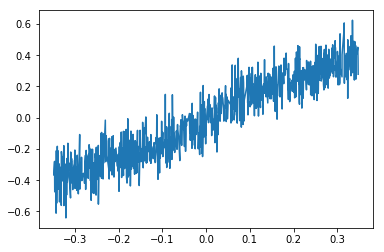

In [13]:
plot(MS.psi0,MS.psi)

The final values for the fit are:
	 Mass:  119544008.204
	 r0:  913.233429435
	 b:  0.00187822497424
	 wvec:  -0.279449444406 0.196657716768 142.76714605
	 time:  454.079071434


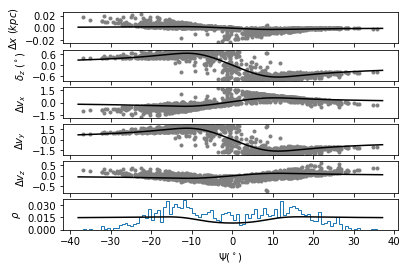

In [14]:
fit = fitData(data,guess)

The final values for the fit are:
	 Mass:  119544008.204
	 r0:  913.233429435
	 b:  0.00187822497424
	 wvec:  -0.279449444406 0.196657716768 142.76714605
	 time:  454.079071434


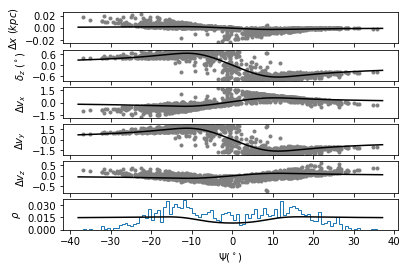

(0.30502016709822616, 0.14277336007477487, 0.14014201931387249) (1.4384096687096357, 0.0025481256467172475, 0.0024493121153017494) (0.0051456862834211217, 0.00014587524233378169, 0.00014162078770625208) (22.667866031256263, 3.5513103013522311, 3.0529378646296799) (-27.726612527756163, 25.55204255835417, 29.892739439719225) (160.64979844379457, 24.655599299490291, 21.004452752173052) (451.94675953004821, 0.1327084371989713, 0.13624604014137276)
Saving to:  MCMC_M1e8_DzDot1.png


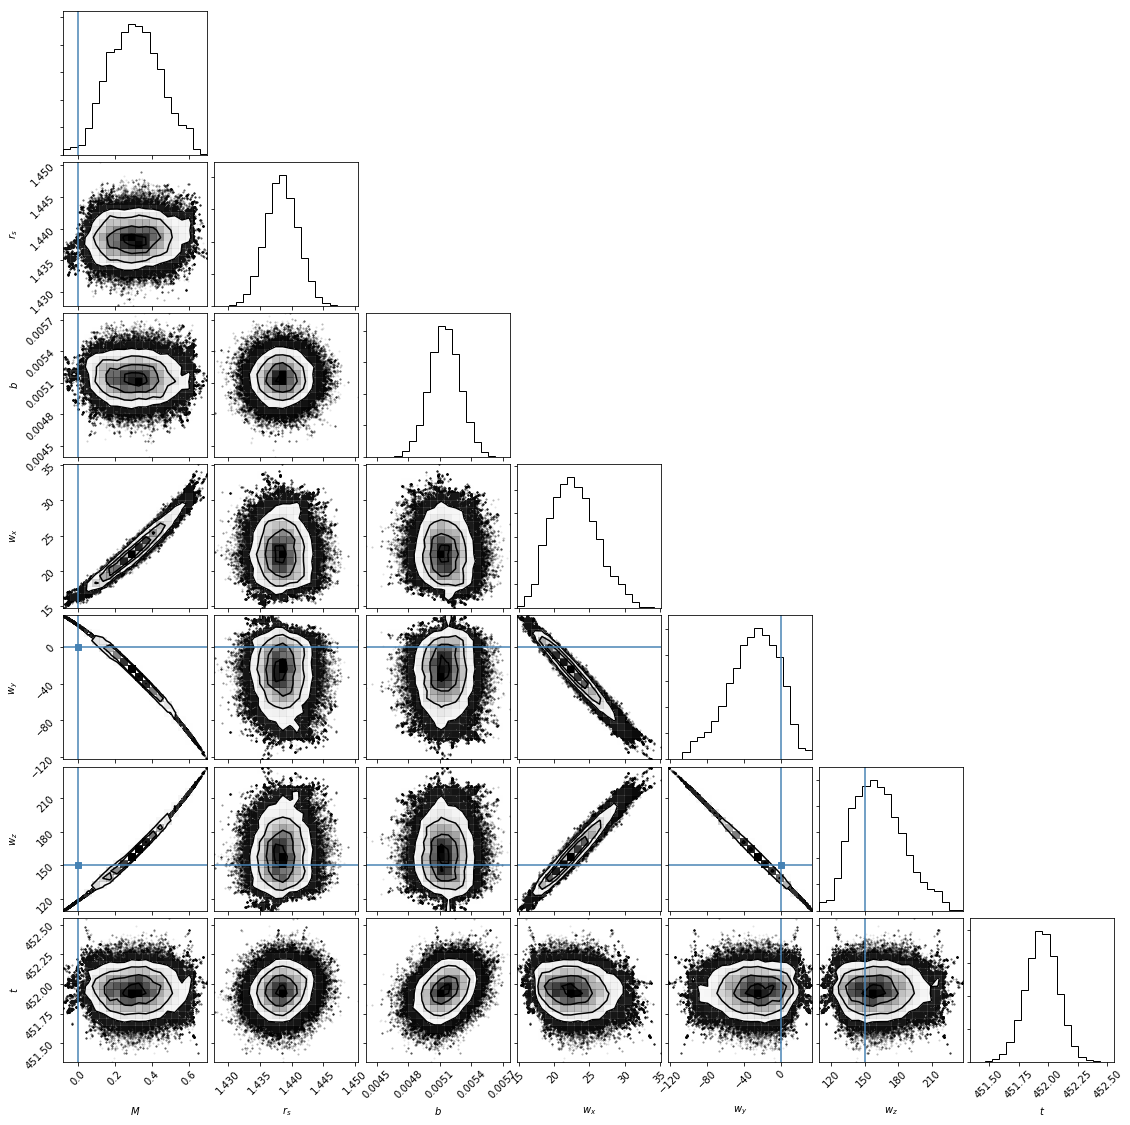

In [15]:
MCMC(guess,data,std,save=True,truth=initial)

In [17]:
mass2 = 1.e8
rs2 = 625.
b2 = 0.
w2 = [0.,0.,150.]
time2 = 450.
nstars2 = 1000
sigmav2 = 5.

stream2 = sm.Stream(mass2,9800.,rs2,b2,w2,time2)
initial2 = [np.log(mass2/1.e8),rs2/625.,b2,w2[0],w2[1],w2[2],time2]

MS = sm.MessyStreamData(mass2,9800.,rs2,b2,w2,time2,nstars2,sigmav2,std)
psidata2 = MS.psi 
dxdata2 = MS.dx
dxdotdata2 = MS.dxdot
data2 = [psidata2,dxdata2,dxdotdata2]
guess2 = [np.log(0.1),250./625.,0.,0.,0.,150.,450.]

The final values for the fit are:
	 Mass:  262419898.995
	 r0:  2530.336594
	 b:  0.0124041296119
	 wvec:  -0.0167350418159 -0.0391658657617 147.138313444
	 time:  450.580826624


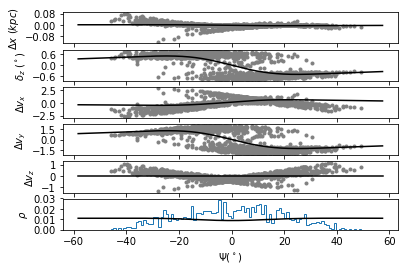

In [18]:
fit2 = fitData(data2,guess2)

The final values for the fit are:
	 Mass:  262419898.995
	 r0:  2530.336594
	 b:  0.0124041296119
	 wvec:  -0.0167350418159 -0.0391658657617 147.138313444
	 time:  450.580826624


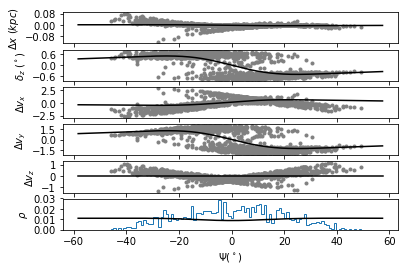

(1.0354714029102574, 0.19263875532446972, 0.18480458397505173) (4.0376993863769668, 0.015129672591390531, 0.015016271458655694) (0.012814747623413329, 0.00077503925407254766, 0.0007644633341073806) (4.6818971905314903, 1.5602881717280326, 1.2720617700631118) (-13.413322980890584, 30.551599974159537, 38.439340548810776) (158.18356889312287, 33.559203586266932, 26.772024268552769) (450.0998967440114, 0.28278906299101436, 0.27950900386900912)
Saving to:  MCMC_M1e8_DzDot1.png


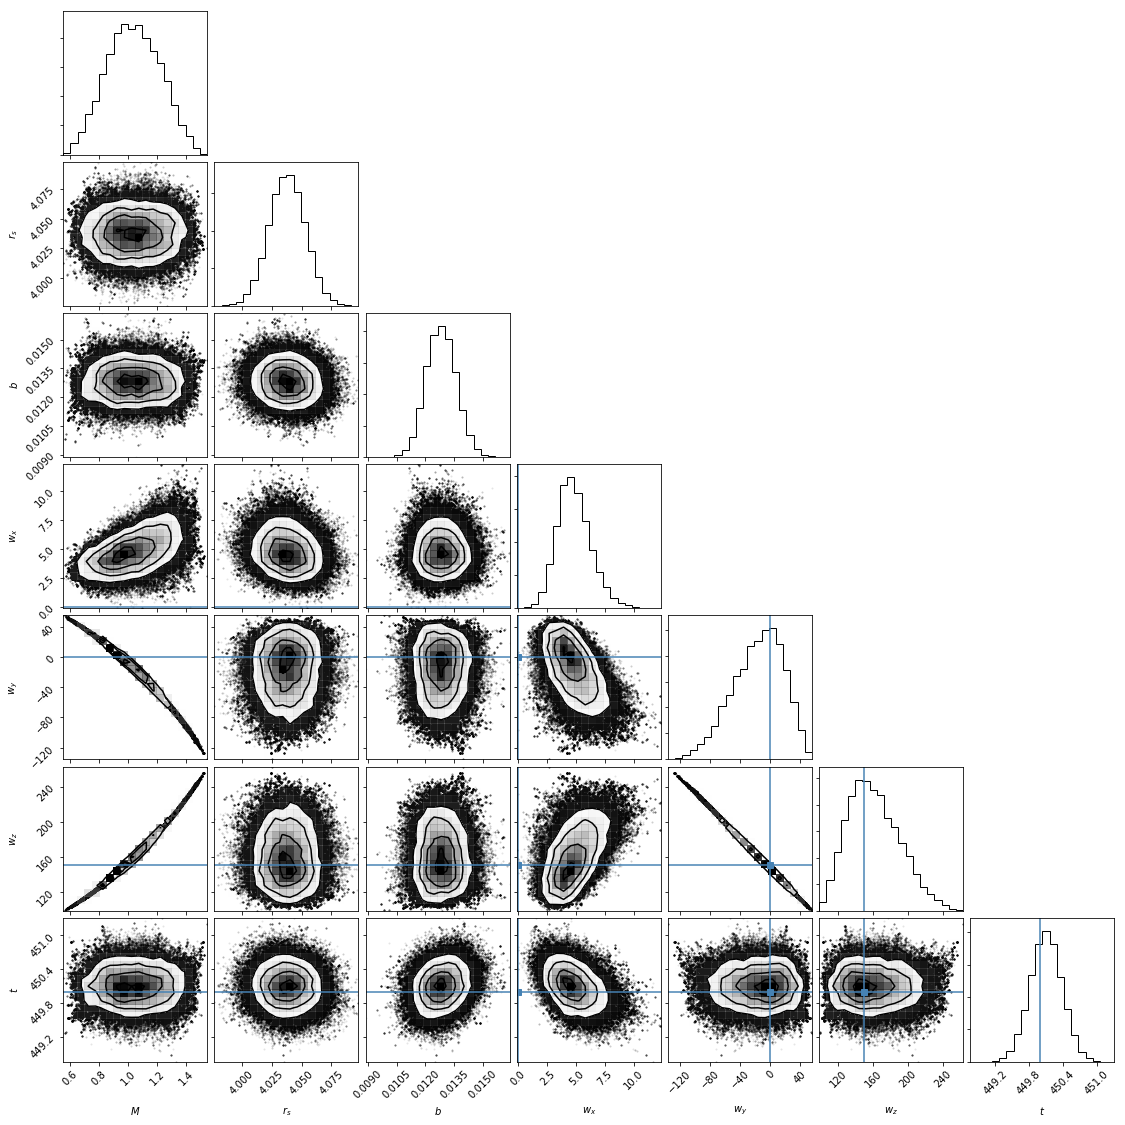

In [19]:
MCMC(guess2,data2,std,save=True,truth=initial2)

In [26]:
mass3 = 1.e8
rs3 = 625.
b3 = 0.
w3 = [0.,0.,150.]
time3 = 250.
nstars3 = 1000
sigmav3 = 0.

stream3 = sm.Stream(mass3,9800.,rs3,b3,w3,time3)
initial3 = [np.log(mass3/1.e8),rs3/625.,b3,w3[0],w3[1],w3[2],time3]

MS = sm.MessyStreamData(mass3,9800.,rs3,b3,w3,time3,nstars3,sigmav3,std)
psidata3 = MS.psi 
dxdata3 = MS.dx
dxdotdata3 = MS.dxdot
data3 = [psidata3,dxdata3,dxdotdata3]
guess3 = [np.log(0.1),250./625.,0.,0.,0.,150.,200.]

The final values for the fit are:
	 Mass:  99790688.7728
	 r0:  624.163583124
	 b:  -7.64774993645e-07
	 wvec:  -0.00749237875407 -0.00638746972707 149.721206476
	 time:  251.485257942


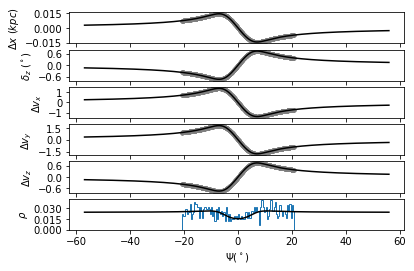

In [27]:
fit3 = fitData(data3,guess3)

The final values for the fit are:
	 Mass:  99790688.7728
	 r0:  624.163583124
	 b:  -7.64774993645e-07
	 wvec:  -0.00749237875407 -0.00638746972707 149.721206476
	 time:  251.485257942


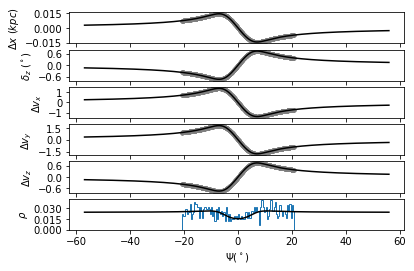

(-0.021107292633726644, 0.12854734772090076, 0.12555393315260047) (0.99964119549536279, 0.00083542358821619978, 0.00084212373153491615) (-6.7469826929566367e-09, 7.9840558036322282e-06, 7.8887045854848742e-06) (0.84723761447908896, 0.14467717165199889, 0.12353367968232398) (3.0148708171709391, 19.391704248598074, 22.599218167093113) (147.26446448050632, 20.20205020753869, 17.387367475829052) (251.33815272108646, 0.017136557286704601, 0.01722413333050099)
Saving to:  MCMC_M1e8_DzDot1.png


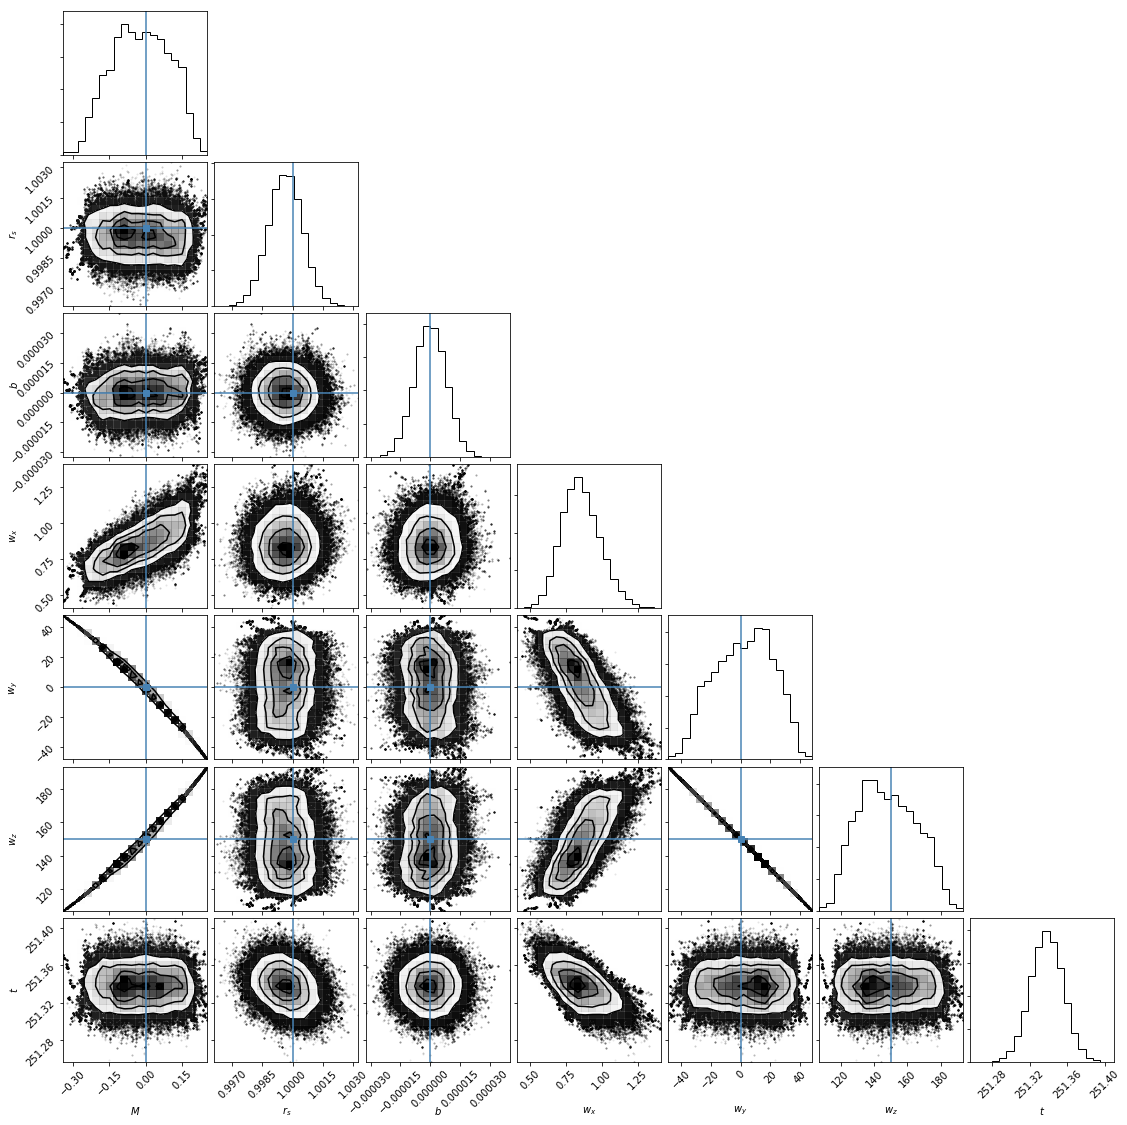

In [28]:
MCMC(guess3,data3,std,save=True,truth=initial3)

The final values for the fit are:
	 Mass:  220665205.985
	 r0:  756.436200797
	 b:  3.52538220772e-05
	 wvec:  0.00145058132307 -0.026954880592 597.915956478
	 time:  484.83692361


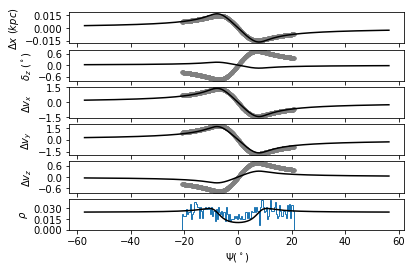

(-0.55514901913164594, 0.13013600620629001, 0.094216621444846549) (0.95105399170483573, 0.0012552297294492476, 0.00106959553369812) (-4.120494614115282e-08, 1.2041636735535575e-05, 1.1739525600137543e-05) (-120.7478140892071, 10.825932148294299, 16.675988659545752) (6.0548614315056106, 15.69080997822039, 22.63401991715741) (61.524124126029108, 8.4527140980379443, 5.6788396704563908) (522.49552287578501, 0.05971340919791146, 0.069067327018501601)


Saving to:  MCMC_M1e8_DzDot1.png


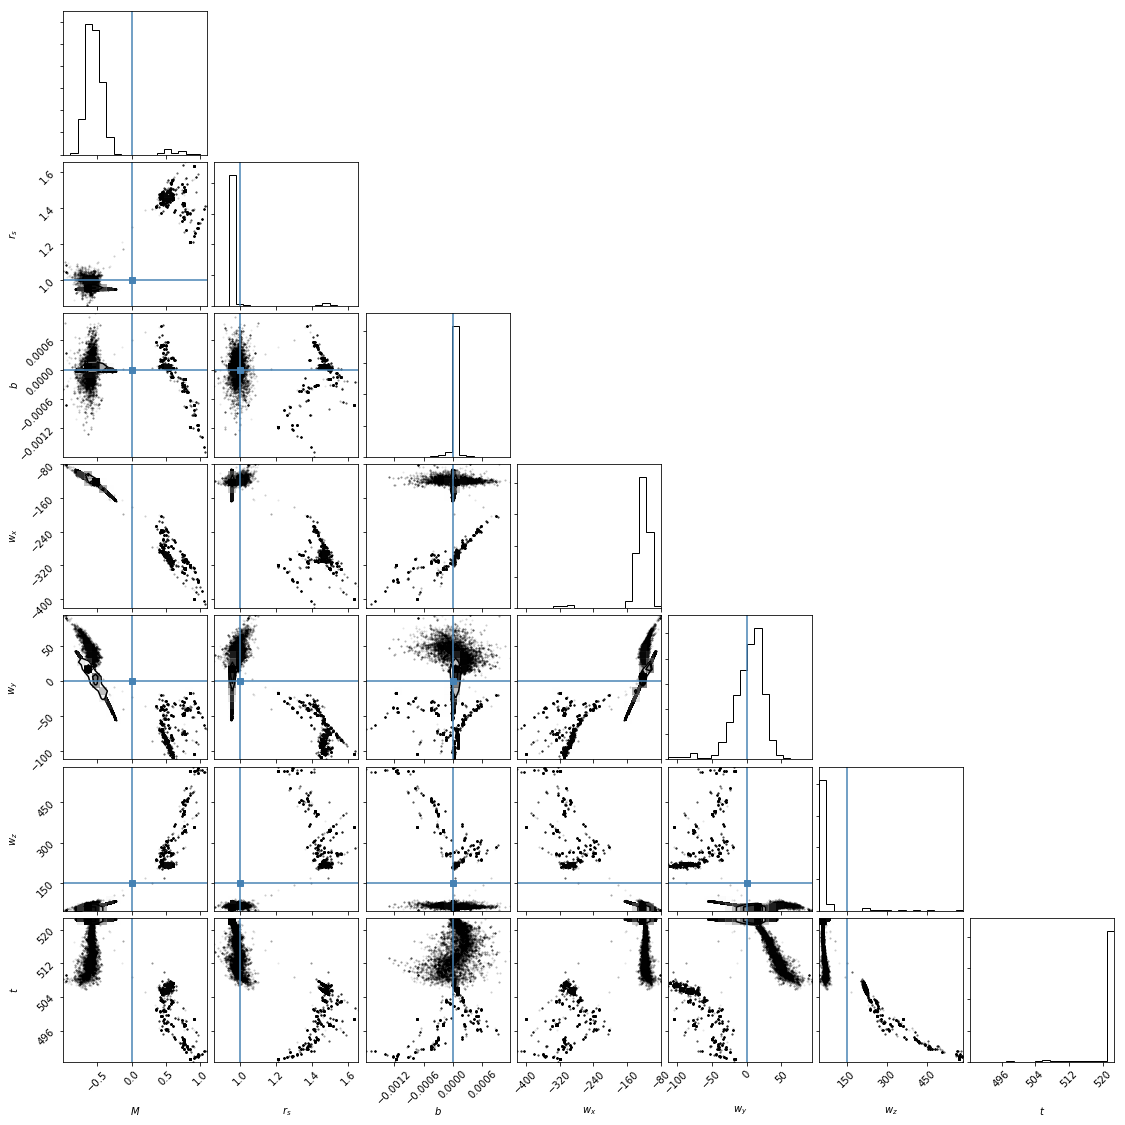

In [29]:
MCMC(guess2,data3,std,save=True,truth=initial3)

In [30]:
mass4 = 1.e8
rs4 = 625.
b4 = 0.
w4 = [0.,0.,150.]
time4 = 250.
nstars4 = 1000
sigmav4 = 5.

stream4 = sm.Stream(mass4,9800.,rs4,b4,w4,time4)
initial4 = [np.log(mass4/1.e8),rs4/625.,b4,w4[0],w4[1],w4[2],time4]

MS = sm.MessyStreamData(mass4,9800.,rs4,b4,w4,time4,nstars4,sigmav4,std)
psidata4 = MS.psi 
dxdata4 = MS.dx
dxdotdata4 = MS.dxdot
data4 = [psidata4,dxdata4,dxdotdata4]
guess4 = [np.log(0.1),250./625.,0.,0.,0.,150.,200.]

The final values for the fit are:
	 Mass:  173050464.606
	 r0:  1523.3950386
	 b:  0.00700642824441
	 wvec:  -0.00998615075294 0.0992930558424 148.86273111
	 time:  251.654263232


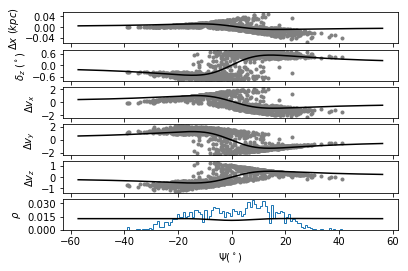

In [31]:
fit4 = fitData(data4,guess4)

The final values for the fit are:
	 Mass:  173050464.606
	 r0:  1523.3950386
	 b:  0.00700642824441
	 wvec:  -0.00998615075294 0.0992930558424 148.86273111
	 time:  251.654263232


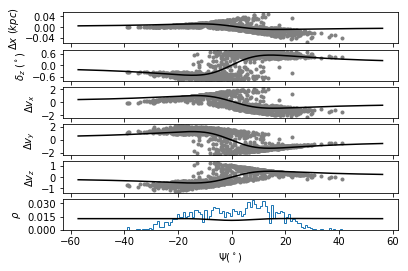

(0.52813732047939044, 0.17920751959498116, 0.21691169927104104) (2.4221021704299046, 0.0085528039091689045, 0.0088527935029389937) (0.0088653684099139363, 0.00031880899202591136, 0.0003209031228198142) (13.5231240233449, 2.7794375549202268, 2.6682222479388695) (3.6020476447253866, 31.89713558687798, 32.157520099059916) (143.92534790043939, 28.312004940029198, 27.980789998257819) (249.8589450558907, 0.16250332320660732, 0.16594182725052065)
Saving to:  MCMC_M1e8_DzDot1.png


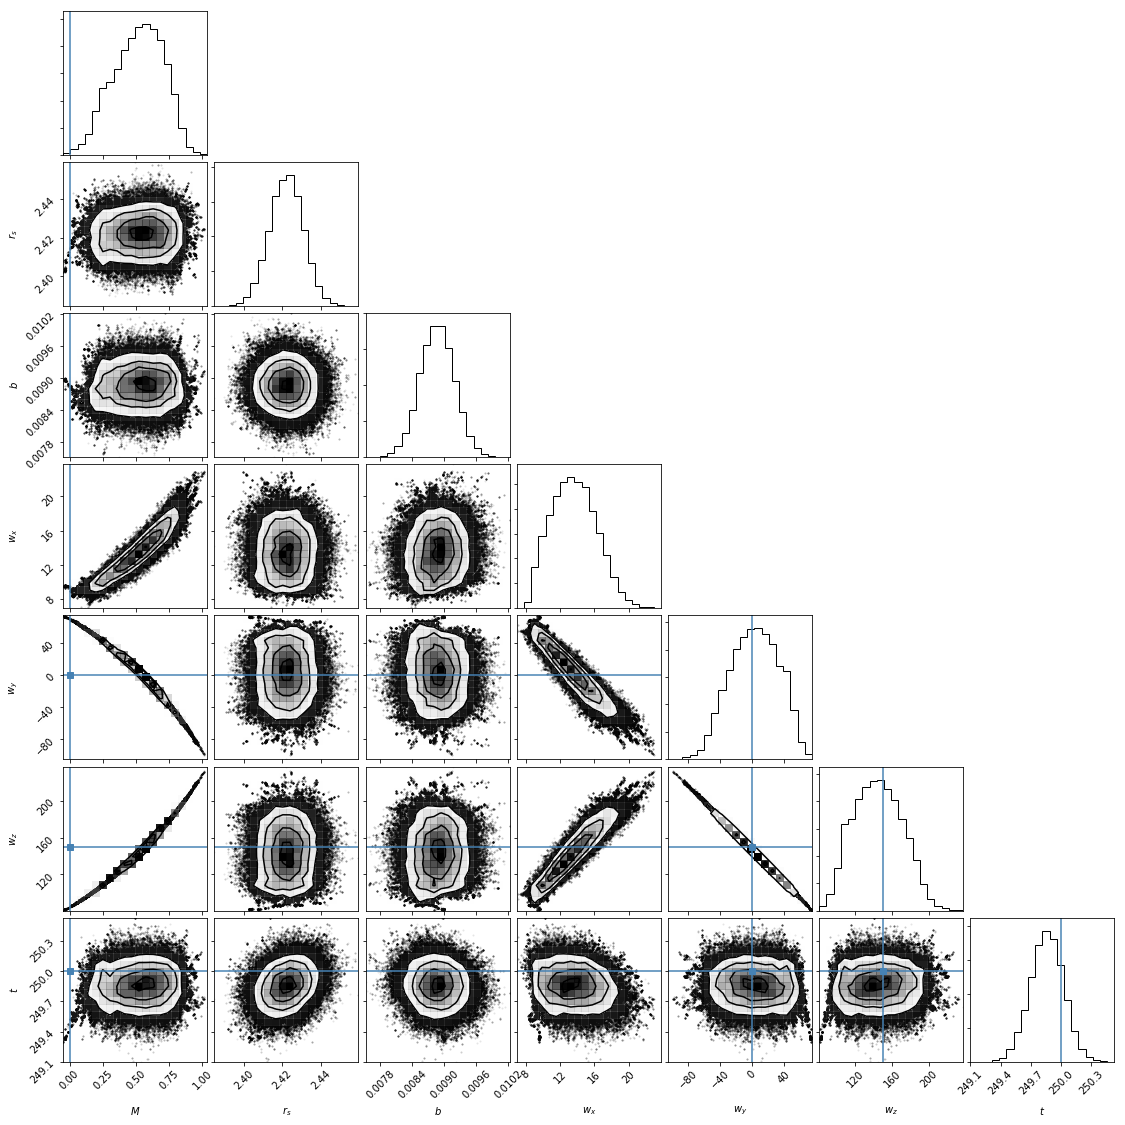

In [32]:
MCMC(guess4,data4,std,save=True,truth=initial4)